# Round-1-Optimized $k$-Vertex Cover

In [JuliQAOA](https://lanl.github.io/JuliQAOA.jl/dev/), the set of angles $\left(\beta_1, \gamma_1\right)$ is typically found via basinhopping starting from a random point. This is implemented with the `guess_angles()` function. The angles in the subsequent rounds are then determined via the method explained in [arXiv:2202.00648](https://arxiv.org/pdf/2202.00648.pdf), section "Angle & Threshold Finding". What if, instead, we started with angles $\left(\beta_1, \gamma_1\right)$ that maximize the expectation value of the cost Hamiltonian, $H_C$? In other words, we want $\left(\beta_1, \gamma_1\right)$ such that

$$F_C\left(\beta_1, \gamma_1\right) = \max_{\beta_1, \gamma_1} \Big\{\left\langle \beta_1, \gamma_1 \left| H_C \right| \beta_1, \gamma_1 \right\rangle \Big\} $$

We will compare the performances of the two angle-finding approaches, starting with the [Dicke state](https://lanl.github.io/JuliQAOA.jl/dev/utils/#JuliQAOA.dicke_states-Tuple{Any,%20Any}) $\big|D^n_k\big\rangle$, for two types of mixers, the [clique](https://lanl.github.io/JuliQAOA.jl/dev/mixers/#JuliQAOA.mixer_clique-Tuple{Int64,%20Int64}) mixer and the [ring](https://lanl.github.io/JuliQAOA.jl/dev/mixers/#JuliQAOA.mixer_ring-Tuple{Int64,%20Int64}) mixer.

**Note:** Many elements in this notebook can be found in [JuliQAOA's Constrained MaxCut example](https://github.com/lanl/JuliQAOA.jl/blob/main/examples/maxcut_kconst.ipynb). While we are considering the maximum $k$-vertex cover problem here, the most important change is the cost function and the selection of $\left(\beta_1, \gamma_1\right)$.

Let's first load the appropriate libraries

In [1]:
using JuliQAOA
using Statistics # for mean function
using Graphs, GraphRecipes, Plots # for graph visualizations
using LinearAlgebra # for norm

In [2202.00648](https://arxiv.org/pdf/2202.00648.pdf), the $k$ is set to $\left\lfloor \frac{|V|}{2} \right\rfloor$, where $|V|$ is the number of vertices in the graph ($n$ in our functions).

## Finding the optimal angles $\beta_1$ and $\gamma_1$ 

In order to find the values of $\beta_1$ and $\gamma_1$ that maximize $\left\langle \beta_1, \gamma_1 \left| H_C \right| \beta_1, \gamma_1 \right\rangle$, we need to first rely on a brute force approach, as described in [arXiv:1910.13483](https://arxiv.org/abs/1910.13483). We will loop over a grid of values $\left(\beta_1, \gamma_1\right)$ with stepsize $0.01 \pi$. This entails determining the domains for $\beta_1$ and $\gamma_1$ themselves obtained from the periods of the mixing Hamiltonian, $H_M$, and the phase-separating Hamiltonian, $H_P$, respectively. 

In this notebook, we use the traditional objective-value-based phase separating approach. Hence, $H_P = H_C$ and the period of the phase separator is $2 \pi$. Consequently, $\gamma_1 \in [0, 2\pi)$. The period for $H_K$, the complete graph mixer (or clique), and the period for $H_R$, the ring mixer, are a bit trickier. From [arXiv:1910.13483](https://arxiv.org/abs/1910.13483), the period of $H_K$ is at most $\pi$.  <font color="red">Question for John: JuliQAOA would give $2\pi$ for the period of the operator. Am I missing something here? <\font> For $H_R$, however, the period is undefined. As a result, we will not be able to determine the appropriate search space for $\beta_1$ when a ring mixer Hamiltonian is employed. We then simply limit the search space to be that of the clique mixer. 

We want to avoid hardcoding as much as possible to keep the functions as useful and applicable as possible. So instead of inputting the periods for the various operators, we take advantage of [JuliQAOA's `get_operator_period()`](https://github.com/lanl/JuliQAOA.jl/blob/main/src/angle_finding.jl) function, which will return the period of an operator, given its eigenvalues. In fact, each instance of a [`Mixer` constructor](https://github.com/lanl/JuliQAOA.jl/blob/main/src/mixers.jl) has a period field in QAOA, that is used in our functions. 
 
Now, the idea is to create a function that is similar to [`find_angles_bh()`](https://github.com/lanl/JuliQAOA.jl/blob/main/src/angle_finding.jl) but starts with optimal values of $(\gamma_1, \beta_1)$, instead of random values. We call this function `find_angles_bh_opt()`, which shares many elements with the original function (docstring included). The main difference between `find_angles_bh_opt()` and `find_angles_bh()` is the call to `find_optimal_angles` and the inclusion of an optional argument random_start. Please see the functions docstrings for more. 

In [2]:
using Optim
using Basinhopping
using LineSearches
import JuliQAOA: guess_angles 

function find_optimal_angles(sv, p, mixer, obj_vals, max=true)
"""
    Determine the optimal angles at each round by going through a grid of solutions with step size 
    0.01*pi, within the precision set by the step size.
    --- Inputs: sv: initial state ``|\\psi_0\\rangle``
                p: number of QAOA rounds
                mixer: QAOA mixing Hamiltonian corresponding to an instance of Mixer
                obj_vals: diagonal of the cost Hamiltonian, ``H_C``
                measure: optional measure
                max: boolean to determine whether we want to maximize or minimize the expectation value
    --- Outputs: max_angles: values of angles ``(\\beta_1, \\gamma_1)`` that lead to the maximum expectation 
                 value \\langle \\beta_1, \\gamma_1 | H_C | \\beta_1, \\gamma_1 \\rangle
                 max_exp_val: maximum expectation value found
"""
    b_min = 0 # minimum value for \beta
    g_min = 0 # minimum value for \gamma
    step_size = 0.01*pi
    obj_vals_period = get_operator_period(obj_vals)
    if obj_vals_period < Inf
        max_angles = Float64[]
        max_exp_val = -Inf
        if mixer.period == Inf 
            b_max = 2*pi # maximum value for \beta for ring mixer 
        else
            b_max = mixer.period
        end
        for round in 1:p
            insert!(max_angles, round, 0) # for beta_{round} value
            insert!(max_angles, 2*round, 0) # for gamma_{round} value
            current_angles = deepcopy(max_angles)
            for b in b_min:step_size:b_max
                for g in g_min:step_size:obj_vals_period
                    current_angles[round] = b
                    current_angles[2*round] = g
                    if (max ? 1 : -1)*exp_value(sv, current_angles, mixer, obj_vals) > max_exp_val
                        max_exp_val = (max ? 1 : -1)*exp_value(sv, current_angles, mixer, obj_vals)
                        max_angles[round] = b
                        max_angles[2*round] = g
                    else
                        continue
                    end
                end
            end
        end
    else
        println("At least one operator has a period that could not be computed.")
    end
    return max_angles, max_exp_val
end


"""
    find_angles_bh2(p, mixer, obj_vals; max=true, niter=100, file=nothing, verbose=true, random_start=false)

Find good angles up for the QAOA defined by `mixer`, `obj_vals` up to `p` rounds.

Uses an iterative, round-by-round angle finding algorithm that combines angle extrapolation
and [basinhopping](https://github.com/gamatos/Basinhopping.jl) to find high quality angles 
up to `p` rounds. See [this](https://arxiv.org/pdf/2202.00648.pdf) paper, section "Angle & 
Threshold Finding" for more details.

Optional arguments:
- `max=false`: determines whether the goal is to minimize or maximize `exp_value`
- `niter=100`: determines the number of basinhopping iterations
- `file=nothing`: save the resulting angles and expectation values in a plain text `file`
- `verbose=true`: print a running log of the angle finding results
- `random_start=false`: determines whether the initial set of angle values is random or not

Additional options:

    find_angles_bh(sv, p, mixer, obj_vals)

Specify the custom initial state ``|\\psi_0\\rangle`` = `sv`.

    find_angles_bh(p, mixer, obj_vals, measure)

Specify a cost function `measure` other than the default ``\\langle H_C \\rangle`` to
maximize/minimize.
    
    find_angles_bh(p, mixer, obj_vals, measure)

Specify both a custom initial state and observable to optimize. 

"""    
function find_angles_bh_opt(p::Int, mixer::Mixer, obj_vals, measure=obj_vals; kwargs...)
    sv = ones(ComplexF64, mixer.N)/sqrt(mixer.N)
    return find_angles_bh_opt(sv, p, mixer, obj_vals, measure; kwargs...)
end

function find_angles_bh_opt(sv::Vector, p::Int, mixer::Mixer, obj_vals::AbstractVector, measure::AbstractVector=obj_vals; max=true, niter=100, file=nothing, verbose=true, random_start=true)
    angles = Vector{Vector{Float64}}()
    exp_vals = Vector{Float64}()
    opt = x0 -> optimize(x->(max ? -1 : 1)*exp_value(sv, x, mixer, obj_vals, measure), 
                   (G,x)->grad!(G, sv, x, mixer, obj_vals, measure; flip_sign=max), 
                   x0, 
                   BFGS(linesearch=LineSearches.BackTracking()))
    i = 1
    while i <= p
        if i == 1 && random_start == false
            new_angles, new_exp_val = find_optimal_angles(sv, i, mixer, obj_vals, max)
            ret = basinhopping(opt, new_angles, BasinhoppingParams(niter=niter)) # gives a very slightly better expectation value, since our step size is not negligible
            new_angles = clean_angles(Optim.minimizer(ret), mixer, obj_vals)
            new_exp_val = (max ? -1 : 1)*minimum(ret)
        else
            x0 = guess_angles(angles)
            ret = basinhopping(opt, x0, BasinhoppingParams(niter=niter))
            new_angles = clean_angles(Optim.minimizer(ret), mixer, obj_vals)
            new_exp_val = (max ? -1 : 1)*minimum(ret)
        end
        push!(angles, new_angles)
        push!(exp_vals, new_exp_val)
        if verbose
            println("done $i rounds, exp. value = $(round(new_exp_val, digits=5))")
        end
        i += 1
        if !isnothing(file)
            save_angle_finding_results(file, angles, exp_vals)
        end
    end
    return angles, exp_vals
end

find_angles_bh_opt (generic function with 4 methods)

## Comparing the approximation ratios at each rounds using ` find_angles_bh()` and ` find_angles_bh_opt()` using 

In [8]:
# The better elements of this are from https://github.com/lanl/JuliQAOA.jl/blob/main/examples/maxcut_kconst.ipynb

n = 8 # number of vertices in the graph
k = floor(Int, n/2) # Hamming weight
p = 10 # total number of rounds to find the optimal angles
p_edge = 0.5 # probability for Erdos-Renyi graph
num_samples = 12 # number of graph samples to be used

# Arrays for different combinations of mixing Hamiltonians and angle-finding functions:
vals_clique = [] 
vals_clique_opt = [] 
vals_ring = []
vals_ring_opt = []

# Loop over samples:
for sample_idx in 1:num_samples
    g = erdos_renyi(n, p_edge)
    println("testing graph #$sample_idx with size $n")
    obj_vals = [kvertex_cover(g,x) for x in dicke_states(n,k)] # Dicke initial state

    # Clique mixer, random (beta_1, gamma_1) 
    mixer_c = mixer_clique(n,k)
    _, scores_clique = find_angles_bh_opt(p, mixer_c, obj_vals; verbose=false, random_start=true)
   
    # Clique mixer, optimal (beta_1, gamma_1) 
    _, scores_clique_opt = find_angles_bh_opt(p, mixer_c, obj_vals; verbose=false, random_start=false)
    
    # Ring mixer, random (beta_1, gamma_1) 
    mixer_r = mixer_ring(n,k)
    _, scores_ring = find_angles_bh_opt(p, mixer_r, obj_vals; verbose=false, random_start=true)
   
    # Ring mixer, optimal (beta_1, gamma_1) 
    _, scores_ring_opt = find_angles_bh_opt(p, mixer_r, obj_vals; verbose=false, random_start=false)
        
    # let's add the approximation ratio that each QAOA begins at
    prepend!(scores_clique, mean(obj_vals))
    prepend!(scores_clique_opt, mean(obj_vals))
    prepend!(scores_ring, mean(obj_vals))
    prepend!(scores_ring_opt, mean(obj_vals))
    
    # convert to approximation ratio so that each graph contributes equally to the mean
    push!(vals_clique, scores_clique / maximum(obj_vals))
    push!(vals_clique_opt, scores_clique_opt / maximum(obj_vals))
    push!(vals_ring, scores_ring / maximum(obj_vals))
    push!(vals_ring_opt, scores_ring_opt / maximum(obj_vals))
end

testing graph #1 with size 8
testing graph #2 with size 8
testing graph #3 with size 8
testing graph #4 with size 8
testing graph #5 with size 8
testing graph #6 with size 8
testing graph #7 with size 8
testing graph #8 with size 8
testing graph #9 with size 8
testing graph #10 with size 8
testing graph #11 with size 8
testing graph #12 with size 8


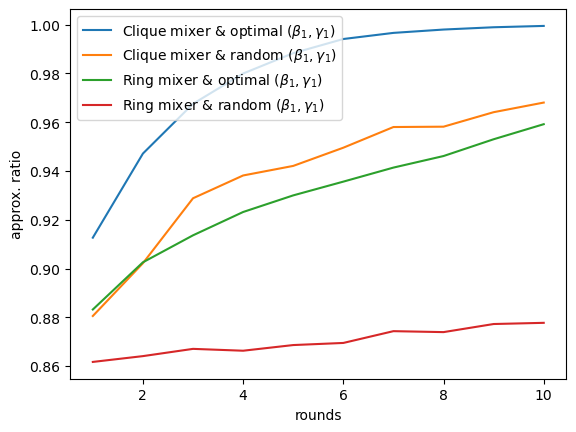

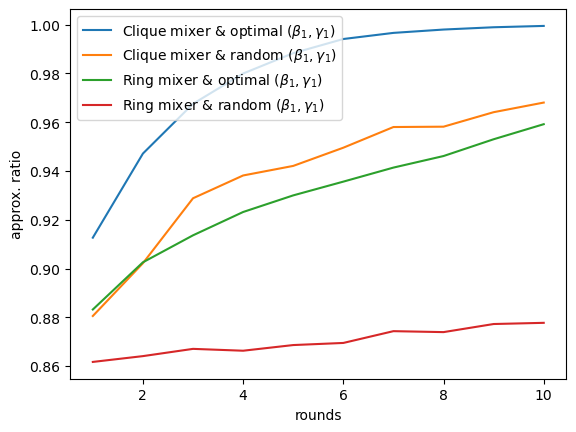

In [9]:
using PyPlot

fig, ax = subplots()

x = 1:p

# Average the round-by-round performance over each instance
    # We start j at 2 because p = 0 corresponds to j = 1. 
    # j ends at p+1 because we add the initial approximation in the loop in the previous cell

y_clique_opt = [mean([vals_clique_opt[i][j] for i in 1:num_samples]) for j in 2:p+1]
ax.plot(x, y_clique_opt, label=L"Clique mixer & optimal $\left(\beta_1, \gamma_1\right)$")

y_clique = [mean([vals_clique[i][j] for i in 1:num_samples]) for j in 2:p+1]
ax.plot(x, y_clique, label=L"Clique mixer & random $\left(\beta_1, \gamma_1\right)$")

y_ring_opt = [mean([vals_ring_opt[i][j] for i in 1:num_samples]) for j in 2:p+1]
ax.plot(x, y_ring_opt, label=L"Ring mixer & optimal $\left(\beta_1, \gamma_1\right)$")

y_ring = [mean([vals_ring[i][j] for i in 1:num_samples]) for j in 2:p+1]
ax.plot(x, y_ring, label=L"Ring mixer & random $\left(\beta_1, \gamma_1\right)$")

ax.set_xlabel("rounds")
ax.set_ylabel("approx. ratio")
ax.legend()
gcf()

In [5]:
println(mean([vals_ring_opt[i][2] for i in 1:num_samples]))
println(mean([vals_clique[i][2] for i in 1:num_samples]))

0.9095850918631271
0.910482261998094
